In [1]:
# General
import os
import pandas as pd
import numpy as np
import math
import sys
import time
import pickle
import json
import datetime
import random

#import sklearn
import sklearn
from sklearn import *

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

import graphviz
import xgboost

# For imbalanced learning
#import imblearn

import warnings
warnings.filterwarnings('ignore')

Змодельовані набори даних висвітлять більшість проблем, з якими стикаються фахівці з виявлення шахрайства, використовуючи дані реального світу. Зокрема, вони включатимуть дисбаланс класів (менше 1% шахрайських транзакцій), поєднання числових і категоріальних ознак (з категоріальними ознаками, що включають дуже велику кількість значень), нетривіальні зв’язки між функціями та шахрайство, що залежить від часу. сценарії.

<h3>Вибір дизайну</h3>

<h4>Функції транзакцій</h4>

Ми зосередимося на найважливіших характеристиках транзакції. По суті, транзакція платіжною карткою складається з будь-якої суми, яку клієнт сплачує продавцю в певний час. Отже, шість основних характеристик, які підсумовують транзакцію, такі:

1. The transaction ID (: унікальний ідентифікатор транзакції
2. The date and time: дата й час здійснення транзакції
3. The customer ID: ідентифікатор клієнта. Кожен клієнт має унікальний ідентифікатор
4. The terminal ID: Ідентифікатор продавця (точніше терміналу). Кожен термінал має унікальний ідентифікатор
5. The transaction amount: сума операції.
6. The fraud label: двійкова змінна зі значенням $0$ для законної транзакції або значенням $1$ для шахрайської транзакції.

Ці функції називатимуться `TRANSACTION_ID`, `TX_DATETIME`, `CUSTOMER_ID`, `TERMINAL_ID`, `TX_AMOUNT` і `TX_FRAUD`.


Заради простоти в цьому розділі не розглядатиметься частина перевірки базової методики навчання під наглядом. Частина перевірки буде розглянута в розділі 5. Розробка нашої системи виявлення шахрайства складатиметься з трьох основних кроків:

1. Визначення навчального набору (історичні дані) і тестового набору (нові дані). Навчальний набір — це підмножина транзакцій, які використовуються для навчання моделі прогнозування. Тестовий набір — це підмножина транзакцій, які використовуються для оцінки ефективності моделі прогнозування.

2. Навчання моделі прогнозування: цей крок полягає у використанні навчального набору для пошуку моделі прогнозування, здатної передбачити, чи є транзакція справжньою чи шахрайською. Ми будемо покладатися на це завдання на бібліотеку Python sklearn, яка надає прості у використанні функції для навчання моделей прогнозування.

3. Оцінка ефективності моделі прогнозування: продуктивність моделі прогнозування оцінюється за допомогою тестового набору (нові дані).

Ми детально описуємо кожен із цих кроків у решті цього розділу.

#### 1. Визначення навчальних і тестових наборів

Навчальний набір спрямований на навчання моделі прогнозування, тоді як тестовий набір спрямований на оцінку ефективності моделі прогнозування на нових даних. У контексті виявлення шахрайства транзакції тестового набору відбуваються хронологічно після транзакцій, використаних для навчання моделі.

Ми використовуватимемо транзакції з 2018-07-25 по 2018-07-31 для навчального набору та з 2018-08-08 по 2018-08-14 для тестового набору. Тижня даних буде достатньо, щоб навчити першу модель прогнозування та оцінити її ефективність. Пізніше ми використаємо більші періоди для навчання та тестування, щоб оцінити, як більші набори можуть вплинути на результати продуктивності.

Варто зазначити, що ми обираємо тестовий набір через тиждень після останньої транзакції навчального набору. У контексті виявлення шахрайства цей період, що розділяє навчальний і тестовий набір, називається періодом затримки або затримкою зворотного зв’язку. Це враховує той факт, що в реальній системі виявлення шахрайства мітка транзакції (шахрайська чи справжня) стає відомою лише після скарги клієнта або завдяки результатам розслідування шахрайства. Таким чином, у реалістичному сценарії анотовані дані, доступні для навчання моделі та початку створення прогнозів на певний день, передують цьому дню мінус період затримки. Встановити період затримки в один тиждень є спрощеним. Припускається, що позначки (шахрайські чи справжні) для всіх транзакцій відомі рівно через тиждень після їх здійснення. На практиці це не так, оскільки затримка може бути меншою, якщо клієнти повідомляють про шахрайство швидко, або набагато довшою у випадках, коли шахрайство залишається непоміченим місяцями. Період затримки фактично є параметром оцінки моделі виявлення шахрайства, який можна налаштувати на етапі перевірки (див. Розділ 5). Тижнева затримка є, на перший погляд, розумною підставою: з досвіду статистика зазвичай показує, що більшість відгуків стає доступною після тижневої затримки.

Давайте завантажимо транзакції з 25.07.2018 по 14.08.2018 і побудуємо графік кількості транзакцій на день, шахрайських транзакцій на день і шахрайських карток на день.

https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_7_DeepLearning/Autoencoders.html

In [2]:
def read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE):
    
    files = [os.path.join(DIR_INPUT, f) for f in os.listdir(DIR_INPUT) if f>=BEGIN_DATE+'.pkl' and f<=END_DATE+'.pkl']

    frames = []
    for f in files:
        df = pd.read_pickle(f)
        frames.append(df)
        del df
    df_final = pd.concat(frames)
    
    df_final=df_final.sort_values('TRANSACTION_ID')
    df_final.reset_index(drop=True,inplace=True)
    #  Note: -1 are missing values for real world data 
    df_final=df_final.replace([-1],0)
    
    return df_final



DIR_INPUT='simulated-data-transformed/data/' 
BEGIN_DATE = "2018-07-25"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))


Load  files
Wall time: 577 ms
201295 transactions loaded, containing 1792 fraudulent transactions


In [3]:
transactions_df.head(4)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,1102483,2018-07-25 00:00:29,1111,2328,40.77,9936029,115,0,0,0,...,24.0,29.191250,105.0,30.141810,1.0,0.0,10.0,0.0,32.0,0.0
1,1102484,2018-07-25 00:01:08,676,6846,9.62,9936068,115,0,0,0,...,15.0,19.151333,61.0,18.253607,2.0,0.0,5.0,0.0,27.0,0.0
2,1102485,2018-07-25 00:01:35,402,4771,81.55,9936095,115,0,0,0,...,11.0,183.875455,50.0,112.001800,0.0,0.0,12.0,0.0,37.0,0.0
3,1102486,2018-07-25 00:01:43,4218,863,23.10,9936103,115,0,0,0,...,24.0,21.201667,93.0,19.987849,2.0,0.0,6.0,0.0,22.0,0.0


In [4]:
def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)

In [5]:
def get_train_test_set(transactions_df,
                       start_date_training,
                       delta_train=7,delta_delay=7,delta_test=7,
                       sampling_ratio=1.0,
                       random_state=0):
    
    # Отримайте дані про навчальний набір
    train_df = transactions_df[(transactions_df.TX_DATETIME>=start_date_training) &
                               (transactions_df.TX_DATETIME<start_date_training+datetime.timedelta(days=delta_train))]
    
    # Отримайте дані набору тестів
    test_df = []
    
    # Примітка. Картки, про які відомо, що вони скомпрометовані після періоду затримки, видаляються з тестового набору
     # Тобто для кожного тестового дня всі випадки шахрайства, відомі в (test_day-delay_period), видаляються
    
     # Спершу, отримайте відомих ошуканих клієнтів із навчального набору
    known_defrauded_customers = set(train_df[train_df.TX_FRAUD==1].CUSTOMER_ID)
    
    # Отримайте відносний день початку навчання (легше, ніж TX_DATETIME збирати тестові дані)
    start_tx_time_days_training = train_df.TX_TIME_DAYS.min()
    
    # Потім для кожного дня тестового набору
    for day in range(delta_test):
    
        # Отримайте тестові дані за цей день
        test_df_day = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                    delta_train+delta_delay+
                                                                    day]
        
        # Зламані картки з цього тестового дня за вирахуванням періоду затримки додаються до пулу відомих ошуканих клієнтів
        test_df_day_delay_period = transactions_df[transactions_df.TX_TIME_DAYS==start_tx_time_days_training+
                                                                                delta_train+
                                                                                day-1]
        
        new_defrauded_customers = set(test_df_day_delay_period[test_df_day_delay_period.TX_FRAUD==1].CUSTOMER_ID)
        known_defrauded_customers = known_defrauded_customers.union(new_defrauded_customers)
        
        test_df_day = test_df_day[~test_df_day.CUSTOMER_ID.isin(known_defrauded_customers)]
        
        test_df.append(test_df_day)
        
    test_df = pd.concat(test_df)
    
    # Якщо підвибірка
    if sampling_ratio<1:
        
        train_df_frauds=train_df[train_df.TX_FRAUD==1].sample(frac=sampling_ratio, random_state=random_state)
        train_df_genuine=train_df[train_df.TX_FRAUD==0].sample(frac=sampling_ratio, random_state=random_state)
        train_df=pd.concat([train_df_frauds,train_df_genuine])
        
    # Сортувати набори даних за зростанням transaction ID
    train_df=train_df.sort_values('TRANSACTION_ID')
    test_df=test_df.sort_values('TRANSACTION_ID')
    
    return (train_df, test_df)

In [6]:
# Обчислити кількість транзакцій на день, шахрайських транзакцій на день і шахрайських карток на день

def get_tx_stats(transactions_df, start_date_df="2018-04-01"):
    
    #Кількість транзакцій на день
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Кількість шахрайських операцій за день
    nb_fraudulent_transactions_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Кількість зламаних карток на день
    nb_compromised_cards_per_day=transactions_df[transactions_df['TX_FRAUD']==1].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    tx_stats=pd.DataFrame({"nb_tx_per_day":nb_tx_per_day,
                           "nb_fraudulent_transactions_per_day":nb_fraudulent_transactions_per_day,
                           "nb_compromised_cards_per_day":nb_compromised_cards_per_day})

    tx_stats=tx_stats.reset_index()
    
    start_date = datetime.datetime.strptime(start_date_df, "%Y-%m-%d")
    tx_date=start_date+tx_stats['TX_TIME_DAYS'].apply(datetime.timedelta)
    
    tx_stats['tx_date']=tx_date
    
    return tx_stats

tx_stats=get_tx_stats(transactions_df, start_date_df="2018-04-01")

In [7]:
%%capture

# Побудуйте графік кількості транзакцій на день, шахрайських транзакцій на день і шахрайських карток на день
# number of transactions per day, fraudulent transactions per day and fraudulent cards per day
def get_template_tx_stats(ax ,fs,
                          start_date_training,
                          title='',
                          delta_train=7,
                          delta_delay=7,
                          delta_test=7,
                          ylim=300):
    
    ax.set_title(title, fontsize=fs*1.5)
    ax.set_ylim([0, ylim])
    
    ax.set_xlabel('Date', fontsize=fs)
    ax.set_ylabel('Number', fontsize=fs)
    
    plt.yticks(fontsize=fs*0.7) 
    plt.xticks(fontsize=fs*0.7)    

    ax.axvline(start_date_training+datetime.timedelta(days=delta_train), 0,ylim, color="black")
    ax.axvline(start_date_test, 0, ylim, color="black")
    
    ax.text(start_date_training+datetime.timedelta(days=2), ylim-20,'Training period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+2), ylim-20,'Delay period', fontsize=fs)
    ax.text(start_date_training+datetime.timedelta(days=delta_train+delta_delay+2), ylim-20,'Test period', fontsize=fs)


cmap = plt.get_cmap('jet')
colors={'nb_tx_per_day':cmap(0), 
        'nb_fraudulent_transactions_per_day':cmap(200), 
        'nb_compromised_cards_per_day':cmap(250)}

# Графік

fraud_and_transactions_stats_fig, ax = plt.subplots(1, 1, figsize=(15,8))

# Training period
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = delta_delay = delta_test = 7

end_date_training = start_date_training+datetime.timedelta(days=delta_train-1)

# Test period
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)
end_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay+delta_test-1)

get_template_tx_stats(ax, fs=20,
                      start_date_training=start_date_training,
                      title='Total transactions, and number of fraudulent transactions \n and number of compromised cards per day',
                      delta_train=delta_train,
                      delta_delay=delta_delay,
                      delta_test=delta_test
                     )

ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
ax.plot(tx_stats['tx_date'], tx_stats['nb_compromised_cards_per_day'], 'b', color=colors['nb_compromised_cards_per_day'], label = '# compromised cards per day')

ax.legend(loc = 'upper left',bbox_to_anchor=(1.05, 1),fontsize=20)

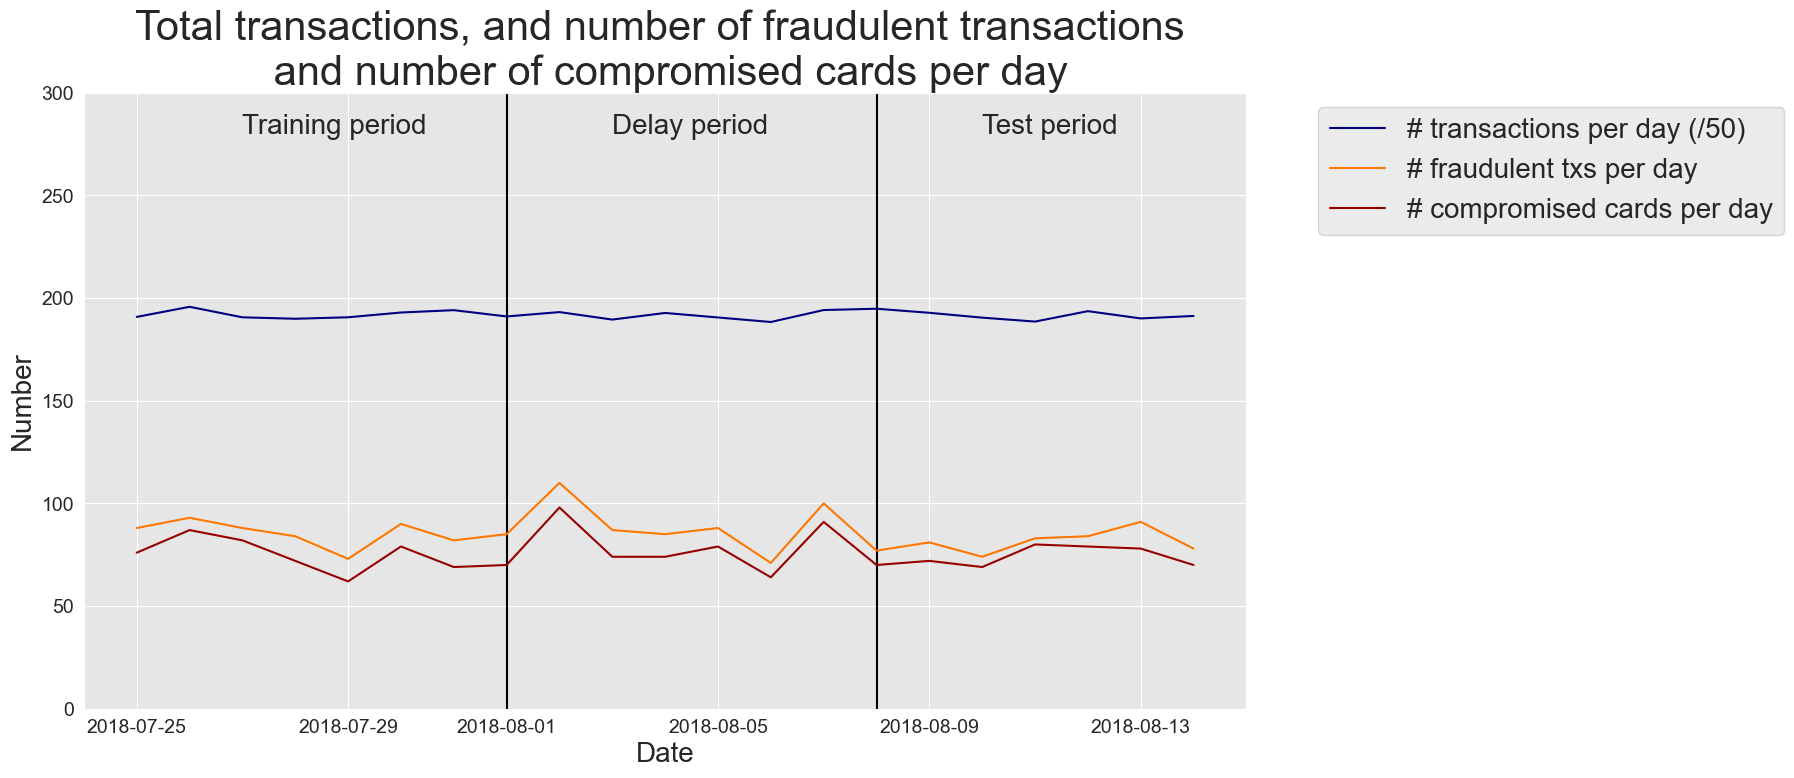

In [8]:
fraud_and_transactions_stats_fig

На малюнку видно, що кількість транзакцій і шахрайств однакова в навчальний і тестовий періоди. Середня кількість шахрайств становить близько 85 на день. 

Давайте витягнемо з набору даних транзакції для навчальної та тестової множини.

In [9]:
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=7,delta_delay=7,delta_test=7)

Навчальний набір містить 67240 транзакцій, серед яких 598 шахрайських.

In [10]:
train_df.shape

(67240, 23)

In [11]:
train_df[train_df.TX_FRAUD==1].shape

(598, 23)

Тестовий набір містить 58264 транзакції, серед яких 385 шахрайських.

In [12]:
test_df.shape

(58264, 23)

In [13]:
test_df[test_df.TX_FRAUD==1].shape

(385, 23)

Тобто частка 0,007 шахрайських транзакцій.

#### 2. Модельне навчання: Дерево рішень¶

Навчання моделі прогнозування полягає у визначенні математичних зв’язків між двома наборами характеристик, які називаються вхідними та вихідними характеристиками. У контексті виявлення шахрайства мета полягає в тому, щоб знайти функцію, яка може передбачити, чи є транзакція шахрайською чи справжньою (функція виводу), використовуючи ознаки, які характеризують транзакції (функції введення).

Ми визначимо вхідні та вихідні характеристики наступним чином:

Вихідною функцією буде мітка транзакції TX_FRAUD 

Вхідними характеристиками буде сума транзакції TX_AMOUNT, а також усі характеристики, обчислені в попередньому розділі, які характеризують контекст транзакції.

In [14]:
output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

У Python навчання моделі передбачення спрощується за допомогою бібліотеки sklearn. Зокрема, бібліотека sklearn забезпечує реалізації для навчання широкого спектру моделей прогнозування.

Навчання моделей прогнозування буде розглянуто більш детально в Розділі 5, Вибір моделі. Наразі ми просто націлимося на навчання деяких стандартних класифікаторів, не вдаючись у подробиці того, як насправді виконується навчання.

Ми почнемо з використання моделі прогнозування, яка називається деревом рішень.

Давайте створимо функцію fit_model_and_get_predictions, яка навчає модель і повертає прогнози для тестового набору. Функція приймає як вхідні дані об’єкт класифікатора sklearn (модель передбачення sklearn), навчальний набір, тестовий набір і набір вхідних і вихідних функцій. Навчальний набір буде використовуватися для навчання класифікатора. Це робиться шляхом виклику методу fit об’єкта класифікатора sklearn. Прогнози класифікатора для навчальних і тестових наборів потім отримують шляхом виклику методу predict_proba об’єкта класифікатора sklearn (див. Розділ 4).

Функція повертає словник, який містить навчений класифікатор, прогнози для навчального набору, прогнози для тестового набору та час виконання для навчання та логічного висновку.

In [15]:
def fit_model_and_get_predictions(classifier, train_df, test_df, 
                                  input_features, output_feature="TX_FRAUD",scale=True):

    # За замовчуванням масштабує вхідні дані
    if scale:
        (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    # Спочатку ми навчаємо класифікатор за допомогою методу `fit` і передаємо як аргументи функції введення та виведення
    start_time=time.time()
    classifier.fit(train_df[input_features], train_df[output_feature])
    training_execution_time=time.time()-start_time

    # Потім ми отримуємо прогнози щодо даних навчання та тестування за допомогою методу predict_proba
     # Прогнози повертаються як масив numpy, який забезпечує ймовірність шахрайства для кожної транзакції
    start_time=time.time()
    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    prediction_execution_time=time.time()-start_time
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    # Результат повертається як словник, що містить підігнані моделі,
     # і прогнози щодо навчальних і тестових наборів
    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train,
                                        'training_execution_time': training_execution_time,
                                        'prediction_execution_time': prediction_execution_time
                                       }
    
    return model_and_predictions_dictionary

Як приклад, навчимо маленьке дерево рішень (з максимальною глибиною 2). Спочатку ми створюємо об’єкт дерева рішень (sklearn.tree.DecisionTreeClassifier) і викликаємо fit_model_and_get_predictions_dictionary, щоб навчити дерево рішень і отримати прогнози для наборів для навчання та тестування.

In [16]:
# Спочатку ми створюємо об’єкт дерева рішень. Ми обмежимо його глибину 2 для інтерпретації,
# і встановіть випадковий стан на нуль для відтворюваності
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 2, random_state=0)

model_and_predictions_dictionary = fit_model_and_get_predictions(classifier, train_df, test_df, 
                                                                 input_features, output_feature,
                                                                 scale=False)

Давайте подивимося на прогнози, отримані для перших п'яти транзакцій тестового набору:

In [17]:
test_df['TX_FRAUD_PREDICTED']=model_and_predictions_dictionary['predictions_test']
test_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW,TX_FRAUD_PREDICTED
134215,1236698,2018-08-08 00:01:14,2765,2747,42.32,11145674,129,0,0,0,...,67.468529,120.0,64.611750,2.0,0.0,9.0,0.0,31.0,0.000000,0.003536
134216,1236699,2018-08-08 00:02:33,714,2073,108.19,11145753,129,0,0,0,...,79.955455,124.0,85.365645,2.0,0.0,10.0,0.0,23.0,0.000000,0.003536
134218,1236701,2018-08-08 00:08:40,4982,1258,26.13,11146120,129,0,0,0,...,56.269167,61.0,49.095902,1.0,0.0,10.0,0.0,26.0,0.076923,0.003536
134219,1236702,2018-08-08 00:08:41,704,8501,65.81,11146121,129,0,0,0,...,62.643333,11.0,63.287273,1.0,0.0,6.0,0.0,23.0,0.000000,0.003536
134220,1236703,2018-08-08 00:10:34,3085,4208,55.22,11146234,129,0,0,0,...,71.993846,72.0,59.899306,1.0,0.0,5.0,0.0,21.0,0.523810,0.003536


Імовірність шахрайства для всіх цих транзакцій становить 0,003536. Ми можемо відобразити дерево рішень, щоб зрозуміти, як були встановлені ці ймовірності:

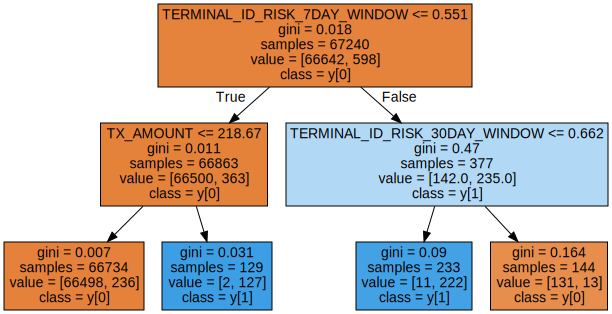

In [18]:
display(graphviz.Source(sklearn.tree.export_graphviz(classifier,feature_names=input_features,class_names=True, filled=True)))

Дерево рішень дозволяє розділити вхідний простір на різні регіони таким чином, щоб шахрайські транзакції відокремлювалися від справжніх транзакцій. Останній рівень дерева (листя) дає кількість шахрайських і справжніх навчальних транзакцій у кожному з цих регіонів. Колір вказує, чи містить вузол чи листок дерева більшість справжніх (помаранчевий) чи шахрайських (синій) транзакцій.

Кожна з п’яти перших транзакцій потрапляє на перший аркуш, регіон, який містить 236 шахрайських транзакцій і 66498 справжніх транзакцій, тобто регіон, де ймовірність шахрайства дорівнює
 
$$\frac{236}{66498+236}=0.003536.$$

Варто зазначити, що дерево рішень правильно виявило, що транзакції з великою сумою є шахрайством (сценарій 1 у процесі створення шахрайства). Відповідна область є другим листом. Однак поріг прийняття рішення (218,67) не є оптимальним, оскільки другий аркуш містить 2 неправильно класифіковані справжні транзакції. Оптимальним пороговим значенням має бути 220, як визначено у сценарії 1, але воно було підігнано лише емпірично з навчальних даних, які представляють вибірку загального розподілу даних.

## 3. оцінка ефективності

Давайте нарешті оцінимо продуктивність цієї моделі дерева рішень. Ми обчислимо три показники продуктивності: AUC ROC, середню точність Average Precision (AP) і точність картки top-$k$ Card Precision top-$k$ (CP@k). Мотивація цих трьох показників буде розглянута в [главі 4] (Performance_Metrics). Наразі достатньо знати, що:

* Card Precision top-$k$ є найбільш прагматичним показником, який можна інтерпретувати. Він бере до уваги той факт, що дослідники можуть перевіряти лише $k$ потенційно шахрайських карток на день. Він обчислюється шляхом ранжування найбільш шахрайських транзакцій для кожного дня в тестовому наборі та вибору $k$ карток, транзакції яких мають найвищу ймовірність шахрайства. Потім для кожного дня обчислюється точність (частка фактично скомпрометованих карток від прогнозованих скомпрометованих карток). Верхня точність картки $k$ — це середнє значення цих щоденних показників точності. Число $k$ буде встановлено на $100$ (тобто передбачається, що щодня можна перевіряти лише 100 карток). (Precision_Top_K_Metrics).
* Середня точність є проксі-сервером для карткової точності top-$k$, який об’єднує точності для всіх можливих значень $k$. (Precision_Recall_Curve).
* AUC ROC є альтернативним показником середньої точності, який надає більшого значення оцінкам, отриманим із вищими значеннями $k$. На практиці це менш доречно, оскільки найбільш важливими є показники для низьких значень $k$. Однак ми також повідомляємо про це, оскільки це найбільш широко використовуваний показник продуктивності для виявлення шахрайства в літературі. (Receiving_Operating_Characteristic_Curve).

Зауважте, що всі три показники надають значення в інтервалі $[0,1]$, і що вищі значення означають кращу продуктивність.

Нижче ми надаємо реалізацію для обчислення цих трьох показників ефективності. Подробиці їх реалізації будуть розглянуті далі (Performance_Metrics).

In [19]:
def card_precision_top_k_day(df_day,top_k):
    
    # Це бере максимум прогнозів та максимум мітки TX_FRAUD для кожного CUSTOMER_ID,
     # і сортує в порядку зменшення шахрайського передбачення
    df_day = df_day.groupby('CUSTOMER_ID').max().sort_values(by="predictions", ascending=False).reset_index(drop=False)
            
    # Отримайте K найпідозріліших карток
    df_day_top_k=df_day.head(top_k)
    list_detected_compromised_cards=list(df_day_top_k[df_day_top_k.TX_FRAUD==1].CUSTOMER_ID)
    
    # Точність обчислень top k
    card_precision_top_k = len(list_detected_compromised_cards) / top_k
    
    return list_detected_compromised_cards, card_precision_top_k


def card_precision_top_k(predictions_df, top_k, remove_detected_compromised_cards=True):

    # Сортувати дні за зростанням
    list_days=list(predictions_df['TX_TIME_DAYS'].unique())
    list_days.sort()
    
    # Спочатку список виявлених зламаних карт порожній
    list_detected_compromised_cards = []
    
    card_precision_top_k_per_day_list = []
    nb_compromised_cards_per_day = []
    
    # Для кожного дня обчисліть точність top k
    for day in list_days:
        
        df_day = predictions_df[predictions_df['TX_TIME_DAYS']==day]
        df_day = df_day[['predictions', 'CUSTOMER_ID', 'TX_FRAUD']]
        
        # Вилучимо виявлені скомпрометовані картки з набору щоденних транзакцій
        df_day = df_day[df_day.CUSTOMER_ID.isin(list_detected_compromised_cards)==False]
        
        nb_compromised_cards_per_day.append(len(df_day[df_day.TX_FRAUD==1].CUSTOMER_ID.unique()))
        
        detected_compromised_cards, card_precision_top_k = card_precision_top_k_day(df_day,top_k)
        
        card_precision_top_k_per_day_list.append(card_precision_top_k)
        
        #Давайте оновимо список виявлених зламаних карт
        if remove_detected_compromised_cards:
            list_detected_compromised_cards.extend(detected_compromised_cards)
        
    # Обчисліть середнє значення
    mean_card_precision_top_k = np.array(card_precision_top_k_per_day_list).mean()
    
    # Повертає найвищу точність k за день у вигляді списку та кінцеве середнє значення
    return nb_compromised_cards_per_day,card_precision_top_k_per_day_list,mean_card_precision_top_k

def performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                           prediction_feature='predictions', top_k_list=[100],
                           rounded=True):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])
    
    for top_k in top_k_list:
    
        _, _, mean_card_precision_top_k = card_precision_top_k(predictions_df, top_k)
        performances['Card Precision@'+str(top_k)]=mean_card_precision_top_k
        
    if rounded:
        performances = performances.round(3)
    
    return performances

Давайте обчислимо продуктивність з точки зору AUC ROC, Average Precision (AP) і Card Precision Top 100 (CP@100) для дерева рішень.

In [20]:
predictions_df=test_df
predictions_df['predictions']=model_and_predictions_dictionary['predictions_test']
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.763,0.496,0.241


Метрика, яку найкраще можна інтерпретувати, це Card Precision@100, яка говорить нам, що щодня 24% карток із найвищими показниками шахрайства справді були зламані. Оскільки відсоток шахрайства в тестовому наборі становить 0,7%, ця частка виявлених шахрайств є високою і означає, що класифікатору справді вдається набагато краще, ніж випадково.

Інтерпретація AUC ROC і Average Precision менш проста. Однак за визначенням відомо, що випадковий класифікатор дасть AUC ROC 0,5 і середню точність 0,007 (частка шахрайства в тестовому наборі). Отримані значення значно вищі (0,764) і (0,496), що підтверджує здатність класифікатора надавати набагато кращі прогнози, ніж випадкова модель.

Примітка. Ефективність для випадкової моделі можна обчислити, просто встановивши всі прогнози на ймовірність $0,5$:

In [21]:
predictions_df['predictions']=0.5
    
performance_assessment(predictions_df, top_k_list=[100])

,AUC ROC,Average precision,Card Precision@100
0,0.5,0.007,0.017


#### 4. Показники з використанням стандартних моделей прогнозування

Тепер у нас є всі будівельні блоки для навчання та оцінки інших класифікаторів. Крім дерева рішень із глибиною 2, давайте навчимо чотири інші моделі прогнозування: *дерево рішень* з необмеженою глибиною, модель *логістичної регресії*, *випадковий ліс* і модель посилення (дивіться комірку імпорту для бібліотеки деталі). Ці моделі найчастіше використовуються в тестах у літературі з виявлення шахрайства.
 
Для цього давайте спочатку створимо словник класифікаторів `sklearn`, який створить екземпляр кожного з цих класифікаторів. Потім ми навчаємо та обчислюємо прогнози для кожного з цих класифікаторів за допомогою функції `fit_model_and_get_predictions`.

In [22]:
classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two':sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }

fitted_models_and_predictions_dictionary={}

for classifier_name in classifiers_dictionary:
    
    model_and_predictions = fit_model_and_get_predictions(classifiers_dictionary[classifier_name], train_df, test_df, 
                                                                                  input_features=input_features,
                                                                                output_feature=output_feature)
    fitted_models_and_predictions_dictionary[classifier_name]=model_and_predictions

Давайте, нарешті, оцінимо продуктивність прогнозування цих п’яти моделей на тестовому наборі та навчальному наборі, а також час їх виконання.

In [23]:
def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test',
                                            top_k_list=[100]):

    performances=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature='TX_FRAUD', 
                                                   prediction_feature='predictions', top_k_list=top_k_list)
        performances_model.index=[classifier_name]
        
        performances=performances.append(performances_model)
        
    return performances

In [24]:
# продуктивність на тестовому наборі
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.870,0.605,0.291
Decision tree with depth of two,0.763,0.496,0.241
Decision tree - unlimited depth,0.788,0.309,0.243
Random forest,0.867,0.658,0.287
XGBoost,0.862,0.639,0.273


In [25]:
# продуктивність на тренувальному наборі
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, train_df, 
                                                        type_set='train', 
                                                        top_k_list=[100])
df_performances

,AUC ROC,Average precision,Card Precision@100
Logistic regression,0.892,0.663,0.419
Decision tree with depth of two,0.802,0.586,0.394
Decision tree - unlimited depth,1.000,1.000,0.576
Random forest,1.000,1.000,0.576
XGBoost,1.000,0.995,0.574


In [26]:
def execution_times_model_collection(fitted_models_and_predictions_dictionary):

    execution_times=pd.DataFrame() 
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        execution_times_model=pd.DataFrame() 
        execution_times_model['Training execution time']=[model_and_predictions['training_execution_time']]
        execution_times_model['Prediction execution time']=[model_and_predictions['prediction_execution_time']]
        execution_times_model.index=[classifier_name]
        
        execution_times=execution_times.append(execution_times_model)
        
    return execution_times

In [27]:
# Терміни виконання
df_execution_times=execution_times_model_collection(fitted_models_and_predictions_dictionary)
df_execution_times

,Training execution time,Prediction execution time
Logistic regression,0.364579,0.020609
Decision tree with depth of two,0.120109,0.009999
Decision tree - unlimited depth,1.607330,0.023113
Random forest,9.224567,0.353060
XGBoost,11.596457,0.169969


Основні висновки цих результатів продуктивності:

* Усі моделі прогнозування вивчили корисні шаблони шахрайства з навчальних даних. Це можна побачити з показника AUC ROC для тестового набору, який перевищує 0,5 для всіх класифікаторів, а середня точність значно перевищує 0,007.
* Моделі випадкового лісу та посилення забезпечують кращі показники (з точки зору середньої точності), ніж логістична регресія та дерева рішень. Про це також широко повідомляється в літературі з виявлення шахрайства.
* Відносні характеристики класифікаторів відрізняються залежно від того, які показники ефективності використовуються. Наприклад, дерево рішень глибини 2 має нижчу AUC ROC, ніж дерево рішень необмеженої глибини, але вищу середню точність. Точне розуміння того, що означають ці показники, має вирішальне значення, і це буде розглянуто в наступному розділі.
* Ефективність деяких класифікаторів (випадковий ліс і дерево рішень з необмеженою глибиною) ідеальна на навчальному наборі (AUC ROC і середня точність 1), але нижча на тестовому наборі. Фактично, дерево рішень з необмеженою глибиною насправді є найгіршим класифікатором у тестовому наборі з точки зору середньої точності. Це приклад явища під назвою *overfitting*, якого слід уникати. Це питання буде розглянуто більш детально далі.
* Як і очікувалося, час виконання для навчальних ансамблів моделей (Випадковий ліс і XGBoost) значно вищий, ніж для окремих моделей (дерева рішень і логістична регресія).